### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import datetime 

2024-06-12 10:53:22.338775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 10:53:22.561999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 10:53:22.562031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 10:53:22.598331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 10:53:22.677947: I tensorflow/core/platform/cpu_feature_guar

### Перевірка застосування графічного процесора

In [2]:
#check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-12 10:53:44.308867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 10:53:44.457389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 10:53:44.457441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Завантажження данних у словник

In [3]:

data = {
    year: {
            "climate": nc.Dataset("data/train/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/train/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [4]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

Одразу позбуваємось даних про вітер на висоті 50 метрів

In [5]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

train_data = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_climate.remove("WS50M")
atributes_climate.remove("WD50M")
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        train_data[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data)


In [6]:
def norm(smth):
    smth = smth - np.min(smth)
    smth = smth/np.max(smth)
    return smth

def log_norm(smth):
    smth = np.log(1 + smth)
    return norm(smth)

In [8]:
sample = train_data["44.25x30.75"]
_sample = {i: log_norm(sample[i]) for i in atributes_climate}
_sample["co_conc"] = log_norm(sample["co_conc"])
sample = pd.DataFrame(_sample)
sample.head()

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc
0,0.269043,0.885004,0.454919,0.567388,0.610355,0.694195,0.297221
1,0.449505,0.822524,0.332772,0.760872,0.449125,0.664428,0.398022
2,0.358171,0.699968,0.439985,0.742353,0.667446,0.673773,0.297877
3,0.190263,0.706666,0.477366,0.651348,0.548200,0.671218,0.287901
4,0.208614,0.810651,0.474516,0.548686,0.624359,0.687206,0.344157


In [9]:
res = sample.get("co_conc")
co = sample["co_conc"].copy()

In [19]:
period = 3 # duration of the forecast is 3 days

for i in range(period):
    co[i] = res[0]

for i in range(period, len(co)):
    co[i] = res[i - period]

sample["co_conc"] = co

In [20]:
model = LinearRegression().fit(sample, res)

In [21]:
model.coef_

array([-0.07150684,  0.03070329,  0.0167644 ,  0.0462289 ,  0.00944231,
       -0.10694461,  0.53639007], dtype=float32)

In [48]:
prediction = np.array(model.predict(sample))[period:]
real = res[period:]
real = real.reset_index(drop=True)

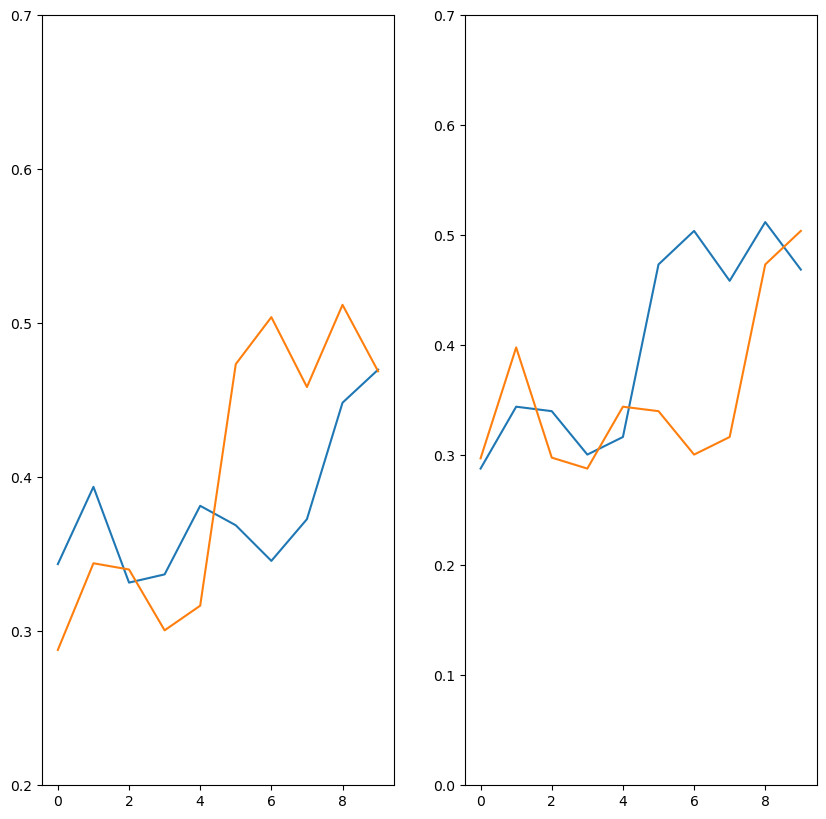

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
n = 10
ax=axes[0]
ax.plot(prediction[:n])
ax.plot(real[:n])
ax.set_ylim([0.2, 0.7])

ax=axes[1]
ax.plot(real[:n])
ax.plot(res[:n])
ax.set_ylim([0, 0.7])

plt.show()